# CW1: Machine Learning Coursework Part 1

You will present your own code that performs nested cross-validation and the k-nearest neighbour algorithm, estimate distances between data samples, build confusion matrices and calculate performance metrics.

The purpose of this coursework is to help you:
- Get familiar with **common python modules / functions** used for ML in python
- Get practical experience **implementing** ML methods in python  
- Get practical experience regarding **parameter selection** for ML methods
- Get practical experience on **evaluating** ML methods and applying cross-validation

Notes:
- Don't use libraries that implement kNN, cross-validation, or any of the performance evaluation functions, unless explicitly asked to do so (or to validate the results of your code).  We want to see your code!
- Remember to comment all of your code. A substantial portion of the marks are given to useful, well-presented code documentation. For more on in-code comments, see here: 
https://medium.freecodecamp.org/code-comments-the-good-the-bad-and-the-ugly-be9cc65fbf83. 
- All functions should be clearly documented using informative docstrings. This should be a clear, textual description of the function inputs and outputs, and what the function does. For more info on docstrings, see here: https://www.programiz.com/python-programming/docstrings. 
- When a question allows a free-form answer (e.g. what do you observe?), create a new markdown cell below and answer the question in the notebook. 
- Save your notebook when you are done.
- The notebook code must execute fully to receive full marks. It is good practice to test this before submission by running Restart and Run all.
- Try to ensure that your notebook and code is clear and well-presented. 

**Plagiarism**: please make sure that the material you submit has been created by you. Any sources you use for code should be properly referenced. Your code will be checked for plagiarism using appropriate software.

----


In [266]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets # import datasets
import numpy as np # import numpy
import matplotlib.pyplot as plt # import plots

# set the seed for the random number generator
mySeed=1234567

# load data
iris = datasets.load_iris() # load data 
X = iris.data # get features
y = iris.target # get targets
print(iris.DESCR) # print dataset description
#print(iris.target)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## 1. Exploratory Data Analysis

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at-hand. The code below loads the iris dataset for you. With only 4 features (sepal length, sepal width, petal length, and petal width), and 3 classes, it is possible to use scatter plots to visualise interactions between different pairings of features. An example of how this visualisation might look is shown below:

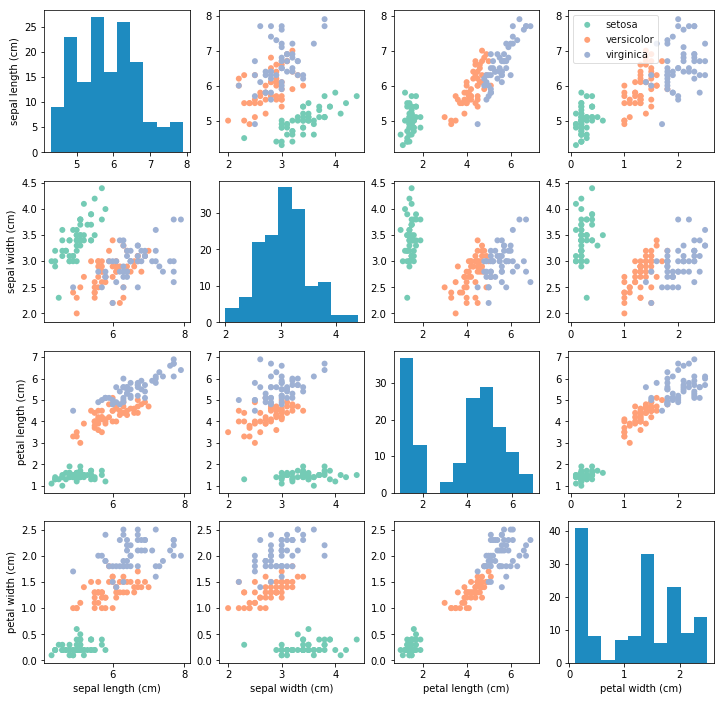

Your first task, drawing on the labs, is to recreate this 4x4 grid, with each off-diagonal subplot showing the interaction between two features, with each of the three classes represented as a different colour. The on-diagonal subplots (representing a single feature) should show a histogram on that feature.     

You should create a function that, given data X and labels y, plots this 4x4 grid.  The function should be invoked as,
        
    myplotGrid(X,y)
    
where X is your training data and y are the labels

----

In [280]:
def myplotGrid(X,y):
    ''' Draws a figure with multiple subplots
        -----------
        Takes: 
            - Data values, 
            - Labels 
        Returns:
            nothing.
        ----------
    '''
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Two feature interaction")
    # Your code here...
    # Split data by class for legend
    dataPerClass=[]
    for i in range(0,3):
        x = [X[j] for j in range(0, len(X)) if y[j]==i]
        dataPerClass.append(np.array(x))
    # Loop over grid
    for i in range(0, 4):
        for j in range(0, 4):
            # add subplot
            ax = fig.add_subplot(4, 4, i+j*4 +1)
            # loop over the three classes
            for l, d in enumerate(dataPerClass):  
                    # Plot hist down the diagonal
                    if i==j:                      
                        plt.hist(d[:, i])
                    # Plot scatter everywhere else
                    else:
                        plt.scatter(d[:,i], d[:,j], label=iris.target_names[l], cmap=plt.cm.Set2)
            # Plot the legend top right
            if i==3 and j ==0:
                plt.legend()
            # Write the axis labels along the edges
            if j == 3:
                ax.set_xlabel(iris.feature_names[i])
            if i == 0:
                ax.set_ylabel(iris.feature_names[j])

    

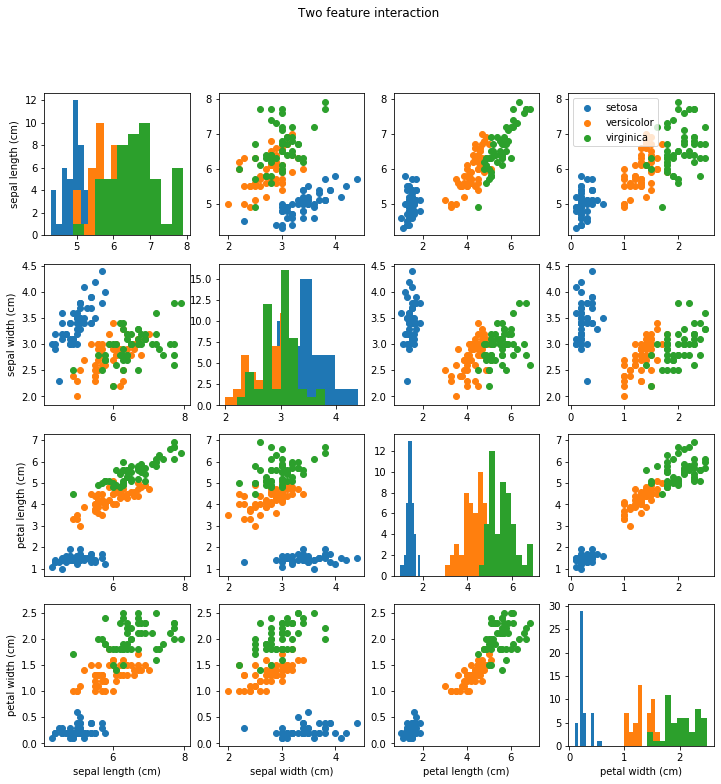

In [281]:
# run the plotting function
myplotGrid(X,y) # visualise data

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings (e.g., from webcams or other errors) they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,

    # initialize random seed to replicate results over different runs
    np.random.seed(mySeed) 
    XN=X+np.random.normal(0,0.5,X.shape)
    
and then invoke

    myplotGrid(XN,y)
    
-----


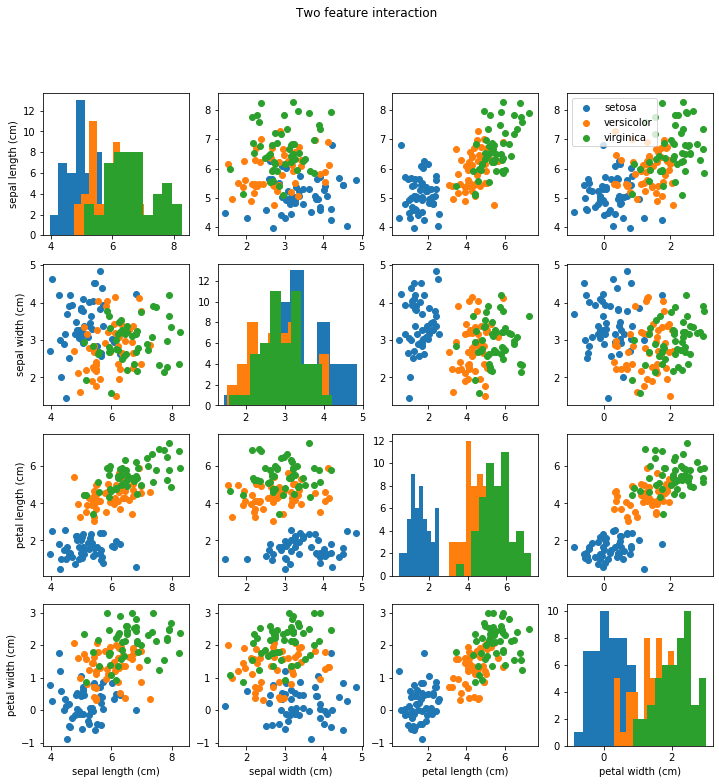

In [269]:
# initialize random seed to replicate results over different runs
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.5,X.shape)
myplotGrid(XN, y)
#print(XN)

## 2. Implementing kNN

In the cell below, develop your own code for performing k-Nearest Neighbour classification.  You may use the scikit-learn k-NN implementation from the labs as a guide -- and as a way of verifying your results -- but it is important that your implementation does not use any libraries other than the basic numpy and matplotlib functions. 

Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

Hint: it helps to break the problem into various sub-problems, implemented as helper function. For example, you might want to implement a separate function for calculating the distances between two vectors, znd another function that uncovers the nearest neighbour(s) to a given vector. 

----

In [287]:
import math, random
import numpy as np
from collections import Counter

# Distance Functions

## Euclidean
def euclidian_dist(a, b):
    ''' Calculate the euclidean distance of two n-dimensional vectors
        ----------
        Takes:
            - a
            - b
        Returns:
            - distance
        ----------
    '''
    return np.linalg.norm(a-b, axis=0)

## Taxicab
def manhattan_dist(a, b):
    ''' Calculate the manhattan distance of two n-dimensional vectors
        ----------
        Takes:
            - a
            - b
        Returns:
            - distance
        ----------
    '''
    assert len(a)==len(b), "The vectors must be the same length"
    result = 0
    for i in range(0, len(a)):
        result += math.fabs(a[i] - b[i])
    return result

"""Train test and split"""
def my_train_test_split(X, y, ts):
    ''' Splits inputs and outputs in ratio given by fraction
        ----------
        Takes: 
            - X, 
            - y, 
            - ts = test size: a number between 0 and 1
        Returns
            - X_train, 
            - X_test, 
            - y_train, 
            - y_test
        ----------
    '''
    # test test size value
    assert (ts > 0.0 and ts < 1.0), "please use a test size bettween 0 and 1"
    # Shuffle X and y
    mySeed=1234567
    np.random.seed(mySeed)
    l = np.arange(X.shape[0])
    l = np.random.permutation(l)
    X = X[l]
    y = y[l]
    # Split X and y using the cut point calculated via the test size fraction  
    cut_point = int(len(X)*(ts))
    X_test = X[0:cut_point]
    y_test = y[0:cut_point]
    X_train = X[cut_point:]
    y_train = y[cut_point:]
    return (X_train, X_test, y_train, y_test)

"""kNN"""
def mykNN(X_train, y_train, X_test, k, distance_type):
    ''' Returns predicted values when given training data and labels, a test set, k neighbours and distance type.
        -----------
        Takes:
           - X=training_inputs, 
           - y=training_outputs, 
           - X=test_inputs, 
           - k=num_of_neighbours, 
           - distance_type= "euclidian" or "manhattan"
        Returns:
           - List of predicted values for test inputs.
        -----------
    '''
    predicted=[]  
    # Fit and predict
    for x in X_test:
        neighbours=[[],[]]
        # Get distances between all data points either euclidian or manhttan
        if distance_type=="euclidean":
            distances = [euclidian_dist(x, j) for j in X_train]
        elif distance_type=="manhattan":
            distances = [manhattan_dist(x, j) for j in X_train]         
        # Get indices of the k smallest within neighbours
        k_nearest_ids = np.argsort(distances)[:k]
        # Get labels for those indices
        k_nearest_labels = [y_train[m] for m in k_nearest_ids]
        # Count the labels 
        counts = np.bincount(k_nearest_labels)
        # Predicted class is most common class
        predicted.append(np.argmax(counts))
    return np.array(predicted)

# # Split
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 0.5)
# # Get predicted values
y_ = mykNN(X_train, y_train, X_test,5, "euclidean")

print("Predicted values: \n")
print(y_)
print("\n")
print("True values: \n")
print(y_test)
print("\n")
print(myAccuracy(y_test, y_))

# Testing against sciKits Knn below:
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234567)
# knn=KNeighborsClassifier(n_neighbors=10, metric='euclidean')
# knn.fit(X_train,y_train)
# y_pred=knn.predict(X_test)
# myAccuracy(y_test, y_pred)

Predicted values: 

[2 1 0 1 1 0 1 2 0 0 1 2 2 0 2 1 0 2 0 0 2 1 0 0 1 1 1 0 2 2 2 0 1 2 0 1 0
 1 0 2 2 1 1 0 0 1 1 0 0 0 1 1 0 2 2 0 0 2 2 1 0 2 1 1 0 2 2 2 1 2 1 2 1 2
 1]


True values: 

[2 1 0 1 1 0 1 2 0 0 1 2 2 0 2 1 0 1 0 0 2 1 0 0 1 1 1 0 2 2 2 0 1 2 0 1 0
 1 0 2 2 1 1 0 0 2 1 0 0 0 1 1 0 1 1 0 0 2 2 1 0 2 1 1 0 2 2 2 1 2 1 2 1 2
 1]


0.9466666666666667


In [284]:
#create a matrix with entries equal to zero, and subsequently build the confusion matrix
#the method should return the confusion matrix in a numpy array
def myConfMat(y_test,y_pred,nClasses):
    ''' Returns a confusion matrix of predicted and ground truth values.
        ----------
        Takes:
            - Array of test data labels
            - Array of predicted values
            - Number of classes
        Returns:
            - nxn Confusion matrix
        ----------
    '''
    # Initialise an n dimensional matrix of zeros
    C = np.zeros((nClasses,nClasses),dtype=np.int)
    # Loop over predicted values updating matrix appropriately
    for i in range(0, len(y_pred)):
        C[y_test[i]][y_pred[i]] +=1
    #loop through all results and update the confusion matrix
    return C

def myPrecision(y_test,y_pred):
    ''' Gets class by class precision 
        ----------
        Takes:
            - Test outputs,
            - Predicted values
        Returns:
            - List with precision for each class  
        ----------
    '''
    # Get array of classes
    classes = np.unique(y_pred)
    # Get number of classes
    n = len(classes)
    # Initialise array of zeros for class by class results
    precision = np.zeros(classes.shape)
    # get confusion matrix
    conf_matrix = myConfMat(y_test,y_pred,n)
    # loop over results and classes
    for i in range(0,n):
        # Initialise true positive + false positive variable
        tp_plus_fp=0
        for j in classes:
            # true positives + false positives
            tp_plus_fp+=conf_matrix[j][i]
        # precision = true positives / true positives + false positives
        class_precision=conf_matrix[i][i]/tp_plus_fp
        precision[i]=class_precision
    return precision

def myRecall(y_test,y_pred):
    ''' Gets class by class Recall 
        ----------
        Takes:
            - Test outputs,
            - Predicted values,
        Returns:
            - List with recall for each class
        ----------
    '''
    # Get array of classes
    classes = np.unique(y_pred)
    # get number of classes
    n = len(classes)
    # output array intialised to zeros
    recall = np.zeros(classes.shape)
    # get confusion matrix
    conf_matrix = myConfMat(y_test,y_pred,n)
    # loop over values and classes
    for i in range(0,n):
        # Initialise true positive plus false negative value to zero
        tp_plus_fn=0
        for j in classes:
            # true positives + false negatives
            tp_plus_fn+=conf_matrix[i][j]
        # recall = true positives / true positives + false negatives
        class_recall=conf_matrix[i][i]/tp_plus_fn
        recall[i]=class_recall
    return recall

#use the numpy function where to return the accuracy given the true/predicted labels.  i.e., #correct/#total
def myAccuracy(y_test,y_pred):
    '''Calculates overall accuracy
        ----------
            Takes:
                - list of test values
                - list of predicted values
            Returns:
                - Accuracy value
        ----------
    '''
    accuracy = len(y_test[np.where(y_test==y_pred)])/len(y_pred) #np.where()
    return accuracy

print("homemade functions:")
print("accuracy: %0.3f" % myAccuracy(y_test,y_))
print('classes:      %s ' % np.unique(y_) )    
print('my precision: %s' % myPrecision(y_test,y_))
print('my recall:    %s \n\n' % myRecall(y_test,y_))

homemade functions:
accuracy: 0.947
classes:      [0 1 2] 
my precision: [1.         0.96153846 0.875     ]
my recall:    [1.         0.89285714 0.95454545] 




## 3. Nested Cross-validation using your implementation of KNN

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. Within this you should write code that evaluates classifier performance. You must write your own code -- the scikit-learn module may only be used for verification purposes. 

Your code for nested cross-validation should invoke your kNN function (see above). You cross validation function should be invoked similary to:

    accuracies_fold, best_parameters_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan']`` evaluates the two distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results. The outputs could be a list of accuracy values, one per fold, and a list of the corresponding parameter tuples ``(distance, k)`` used to calculate these.

**Notes:** 
- you should perform nested cross-validation on both your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should implement/validate **at least** two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold, and a list of the corresponding parameters
- for each **fold**, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)

----

In [274]:
''' Nested Cross Validation of KNN'''
def myNestedCrossVal(X,y,foldK,nns,dists,mySeed):
    """ Nest Cross Validation of Knn.
        ----------
        Takes: 
            - inputs, 
            - outputs, 
            - number of folds, 
            - list: range of neighbour values, 
            - list of distance names: "euclidean","manhattan"
            - random seed.
        Returns: 
            - list of accuracies, 
            - list of parameters, 
            - list of confusion matrices
        ----------
    """
    np.random.seed(mySeed)
    accuracy_fold=[]
    parameters_fold=[]
    conf_matrices=[]
    #TASK: use the function np.random.permutation to generate a list of shuffled indices from in the range (0,number of data)
    #(you did this already in a task above)
    L=list(range(X.shape[0]))
    indices = np.random.permutation(L)
    #TASK: use the function array_split to split the indices to foldK different bins (here, 5)
    #uncomment line below
    bins=np.array_split(indices, foldK)
    #print(bins)
    #no need to worry about this, just checking that everything is OK
    assert(foldK==len(bins))
    #loop through folds
    for i in range(0,foldK):
        foldTrain=[] # list to save current indices for training
        foldTest=[]  # list to save current indices for testing
        foldVal=[]    # list to save current indices for validation
        #loop through all bins, take bin i for testing, the next bin for validation, and the rest for training
        valBin = (i+1)%foldK
        for j in range(0,len(bins)):
            if (i == j):
                foldTest = bins[i]
            elif (j == valBin):
                foldVal = bins[valBin]
            else:
                foldTrain.extend(bins[j])

        #no need to worry about this, just checking that everything is OK
        #assert not np.intersect1d(foldTest,foldVal)
        #assert not np.intersect1d(foldTrain,foldTest)
        #assert not np.intersect1d(foldTrain,foldVal)
        bestDistance='' #save the best distance metric here
        bestNN=-1 #save the best number of neighbours here
        bestAccuracy=-10 #save the best attained accuracy here (in terms of validation)
        # loop through all parameters (one for loop for distances, one for loop for nn)
        # train the classifier on current number of neighbours/distance
        # obtain results on validation set
        # save parameters if results are the best we had
        for d in dists:
            for nn in nns:
                #split to train and test
                #define knn classifier, with 5 neighbors and use the euclidian distance
                #knn=KNeighborsClassifier(n_neighbors=nn, metric=d)
                #knn.fit(X[foldTrain],y[foldTrain])
                y_pred=mykNN(X[foldTrain],y[foldTrain],X[foldVal],nn,d)
                accuracy = myAccuracy(y[foldVal], y_pred)
                if accuracy > bestAccuracy:
                    bestDistance = d
                    bestNN = nn
                    bestAccuracy = accuracy
        #evaluate on test data:
        #extend your training set by including the validation set
        #train k-NN classifier on new training set and test on test set
        #get performance on fold, save result in accuracy_fold
        foldTrain.extend(foldVal)
        # knn on fold
        y_=mykNN(X[foldTrain],y[foldTrain], X[foldTest], bestNN,bestDistance)
        # calculate accuracy of fold and append to array
        accuracy_=myAccuracy(y[foldTest],y_)
        accuracy_fold.append(accuracy)
        # store parameters
        parameters_fold.append((bestDistance, bestNN))
        # get number of classes
        nClasses = len(np.unique(y_))
        # get and store confusion matrix
        conf_matrix=myConfMat(y[foldTest],y_,nClasses)
        conf_matrices.append(conf_matrix)
        #print('==== Final Cross-val on test on this fold with NN', bestNN, 'dist', bestDistance, ' accuracy ',myAccuracy(y[foldTest],y_))

    return accuracy_fold, parameters_fold, np.array(conf_matrices);

In [285]:
#Clean
# Do nested cross validated k nearest neighbour on clean data
dists=["euclidean", "manhattan"]
mySeed=123456
kFolds=5
# Do nested cross val
accuracies_fold, best_parameters_fold, conf_matrices = myNestedCrossVal(X,y,kFolds,list(range(1,11)),dists,mySeed)
# calc averaget accuracy
avg_accuracy = np.average(accuracies_fold)
# calc standard deviation
sd = np.std(accuracies_fold)

# Formatting
import pandas
columns=(["accuracy", "k", "distance"])
rounded_accuracies=["{0:.2f}".format(i) for i in accuracies_fold]
dist_metrics=[best_parameters_fold[i][0] for i in range(0,len(best_parameters_fold))]
nns=[best_parameters_fold[i][1] for i in range(0,len(best_parameters_fold))]
data = np.array([rounded_accuracies,nns,dist_metrics])
df=pandas.DataFrame(data.T,np.arange(1,kFolds+1), columns,)
print("Clean")
print("\nTotal accuracy: %8.3f ± %8.3f" % (avg_accuracy,  sd))
df

Clean

Total accuracy:    0.967 ±    0.021


,accuracy,k,distance
1,0.97,1,euclidean
2,1.00,6,euclidean
3,0.93,3,euclidean
4,0.97,3,euclidean
5,0.97,3,euclidean


In [278]:
#Noisey
# Do nested cross validated k nearest neighbour on noisey data
noisey_accuracies_fold, noisey_best_parameters_fold, noisey_conf_matrices = myNestedCrossVal(XN,y,kFolds,list(range(1,11)),dists,mySeed)
noisey_avg_accuracy = np.average(noisey_accuracies_fold)
sd = np.std(noisey_accuracies_fold)

# Formatting 
columns=(["accuracy", "k", "distance"])
noisey_rounded_accuracies=["{0:.2f}".format(i) for i in noisey_accuracies_fold]
noisey_dist_metrics=[noisey_best_parameters_fold[i][0] for i in range(0,len(noisey_best_parameters_fold))]
noisey_nns=[noisey_best_parameters_fold[i][1] for i in range(0,len(noisey_best_parameters_fold))]
noisey_data = np.array([noisey_rounded_accuracies,noisey_nns,noisey_dist_metrics])
noisey_df=pandas.DataFrame(noisey_data.T,np.arange(1,kFolds+1), columns,)
print("Noisey")
print("\nTotal accuracy: %8.3f ± %8.3f" % (noisey_avg_accuracy,  sd))
noisey_df

Noisey

Total accuracy:    0.867 ±    0.063


,accuracy,k,distance
1,0.80,2,manhattan
2,0.97,2,euclidean
3,0.87,5,euclidean
4,0.80,4,euclidean
5,0.90,1,euclidean


### 3.2. Summary of results

Using your results from above, fill out the following table using the **clean** data:

**SEE ABOVE**

Now fill out the following table using the **noisy** data:

**SEE ABOVE**


### 3.3. Confusion matrix summary

Summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data). You might want to adapt your code above to also return a list of confusion matrices (one for each fold),
 e.g.
 
    accuracies_fold, best_parameters_fold, confusion_matrix_fold = myNestedCrossValConf(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)

Then write a function to print the two matrices below. Make sure you label the matrix so that it is readable. You might also show class-relative precision and recall. 

----

In [286]:
def myPrecision(conf_matrix):
    ''' Gets class by class precision 
        ----------
        Takes:
            Confusion Matrix
        Returns:
            List with precision for each class            
    '''
    # get classes
    classes = np.unique(y)
    # initialise array of zeros for results
    precision = np.zeros(classes.shape)
    for i in range(0,len(conf_matrix)):
        tp_plus_fp=0
        for j in classes:
            # true positives + false positives
            tp_plus_fp+=conf_matrix[j][i]
        # precision = true positives / true positives + false positives
        class_precision=conf_matrix[i][i]/tp_plus_fp
        precision[i]=class_precision
    return precision

def myRecall(conf_matrix):
    ''' Gets class by class Recall 
        ----------
        Takes:
            Confusion Matrix
        Returns:
            List with recall for each class  
        ----------
    '''
    # classes
    classes = np.unique(y)
    # results array of zeros
    recall = np.zeros(classes.shape)
    # loop over confusion matrixes  and calc results
    for i in range(0,len(conf_matrix)):
        tp_plus_fn=0
        for j in classes:
            # true positives + false negatives
            tp_plus_fn+=conf_matrix[i][j]
        # recall = true positives / true positives + false negatives
        class_recall=conf_matrix[i][i]/tp_plus_fn
        recall[i]=class_recall
    return recall

def summary_matrices_print(conf_matrices):
    ''' Creates a summary confusion matrix
        ----------
        Takes:
            Confusion Matrix
        Returns:
            List with recall for each class     
        ----------
    '''    
    conf=np.zeros(conf_matrices[0].shape)
    for c in conf_matrices:
        conf=np.add(conf,c)    
    print("Summary confusion matrix of data: \n")
    print(conf,"\n")
    precision = myPrecision(conf)
    print("Class-relative precision for classes (0,1,2): %s" %precision)
    recall = myRecall(conf)
    print("Class-relative recall for classes (0,1,2): %s" %recall)
    

print("Clean data\n")
summary_matrices_print(conf_matrices)
print("Accuracy: %8.2f"%avg_accuracy)
print("\n\nNoisey data\n")
summary_matrices_print(noisey_conf_matrices)
print("Accuracy: %8.2f"%noisey_avg_accuracy)

Clean data

Summary confusion matrix of data: 

[[50.  0.  0.]
 [ 0. 46.  4.]
 [ 0.  2. 48.]] 

Class-relative precision for classes (0,1,2): [1.         0.95833333 0.92307692]
Class-relative recall for classes (0,1,2): [1.   0.92 0.96]
Accuracy:     0.97


Noisey data

Summary confusion matrix of data: 

[[50.  0.  0.]
 [ 1. 41.  8.]
 [ 0. 17. 33.]] 

Class-relative precision for classes (0,1,2): [0.98039216 0.70689655 0.80487805]
Class-relative recall for classes (0,1,2): [1.   0.82 0.66]
Accuracy:     0.87


## 4. Questions 

Now answer the following questions as fully as you can. The answers should be based on your implementation above. Write your answers in new Markdown cells below each question.

### Q1. Choice of parameters
Do the best parameters change per fold? Is there one parameter choice that is best regardless of the data used?

#### Answer: 

Yes the value of k is varied, although distance type stays the same apart from one noisey round where manhattan came out better.

### Q2.	 Clean vs. noisy
Does the best parameter choice change depending on whether we use clean or noisy data? (Answer for both distance function and number of neighbours.)

#### Answer:

Values of k are quite varied whereas distance is all euclidian,with one manhattan.

### Q3. Exploratory data analysis
Looking again at the exploratory data analysis, what do you observe by plotting the figure for data without noise? What do you observe when you add Gaussian noise and plot again? 

#### Answer:
When the noise is the three classes have more cross over and are not so distinctly seperated. Before noise they are seperated more spatially.

### Q4. Tie break
Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.

#### Answer:
I would take the class of the closest value.

In [ ]:
neighbours=[()]

if len(neighbours) == 2 and neighbours.unique() == 2:
    # In my kNN implementation the first in the sorted neighbours array would be the closest.
    outclass = neighbours[0]

### Q5.	Improving performance on noisy data. 
The performance of k-NN on the noisy data should be worse than on the clean data. Suggest at least one way of improving the performance on the noisy data. Try to elaborate on your idea as much as possible, including pseudocode where possible.

#### Answer:

Using a weighting system so that alongside distance there each neighbour has a weight attached which is a measure of how likely (a probability) it is to be that class. The weight would be used alongside the distance to determine  the class.